In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
from matplotlib import rcParams as rc
import matplotlib as mpl
import matplotlib.pylab as pl
# import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker
import matplotlib.tri as tri
import decimal
from scipy.integrate import simps


In [2]:
def moving_avg(x_data,window):
    # return x_data
    return np.convolve(x_data,np.ones(int(window)),'valid')/window


8
8
0.0 1.0 0.2599961748295029
8
8
8
8
8


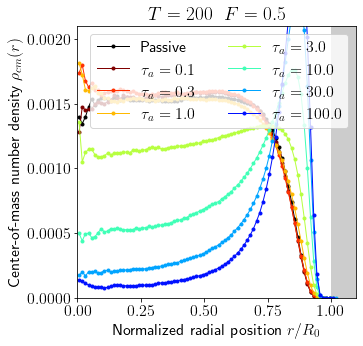

In [131]:
# print(mpl.rcParams.keys)
mpl.rcParams.update({'font.size':16, 'text.usetex':True, 'figure.figsize':(5,5)})
colors = pl.cm.jet_r(np.linspace(0,1,8))
tp=1
fpath='../../data_new/SAC_R020_N40/'
fpath='../../data_new/SAC_R020/'
for fpath in ['../../data_new/RC_R020_N40/']:#,'../../data_new/SAC_R020/', '../../data_new/RC_R020_N100/']:
    ind=3
    fnames=sorted([xx for xx in os.listdir(fpath+'RDP/') if '.npz' in xx],key=lambda x: float(x.split('_')[ind+2].replace('Ta','')))
    
    Ts,Tas,Fs=[],[],[]
    Peak,Prob_center=[],[]
    R_pmax_b=[[],[]]
    p1_eq=0
    jj=0
    for fname in fnames:
        if '.npz' in fname and 'RadNumDens' in fname and 'rep1' in fname:
            if 'com' not in fname:continue

            T= float(fname.split('_')[ind].replace('T',''))
            F=float(fname.split('_')[ind+1].replace('F',''))
            Ta=float(fname.split('_')[ind+2].replace('Ta',''))
            kb=float(fname.split('_')[ind+7].replace('kb',''))
            Esoft=float(fname.split('_')[ind+3].replace('Esoft',''))
            R0=float(fname.split('_')[ind+4].replace('R0',''))
            dt=float(fname.split('_')[ind+8].replace('dt',''))

            Ts.append(F**2*Ta/(0.1*0.0083*T))
            Tas.append(Ta/tp)
            Fs.append(F)

            R_pmax_b[1].append(F**2*Ta/(0.1*200*0.0083))
            
            npzfile=np.load(fpath+'RDP/'+fname)
            hist,bins=npzfile['hist'],npzfile['bins']
            n0,n1,n2=int(bins.shape[0]*0.),int(bins.shape[0]*0.4), int(bins.shape[0]*0.6)

            Nrep=1
            for index in range(2,10):
                fname_rep=fname.replace('rep1','rep{}'.format(index))

                if fname_rep in fnames:
                    # print(fname_rep)
                    repfile=np.load(fpath+'RDP/'+fname_rep)
                    try:
                        hist+=repfile['hist'][:len(hist)]
                        Nrep+=1
                    except(ValueError,):
                        val=repfile['hist']
                        hist+=np.pad(val, (0,hist.shape[0]-val.shape[0]))
                        Nrep+=1
            if 'com' not in fname: hist=hist/(Nrep)
            else: hist=hist/(Nrep)
            
            #!!!
            r_pmax=[bins[x] for x,y in enumerate(hist) if y==hist[1:].max()]
            # print(len(r_pmax))
            R_pmax_b[0].append(r_pmax[0])

            dp=np.gradient(hist)/np.gradient(bins)

            p1=simps(bins[n0:n1]**2*4*np.pi*hist[n0:n1]/12,bins[n0:n1])
            p3=simps(bins[n2:]**2*4*np.pi*hist[n2:]/12,bins[n2:])

            #check at boundary if there is a peak: dp should cross zero once
            cross_count_dp=0
            for ix in range(n2,len(dp)-1):
                if np.sign(dp[ix])!=np.sign(dp[ix+1]):
                    cross_count_dp+=1

            state=None
            if cross_count_dp==2: state='boundary-peak'
            elif cross_count_dp>2: state='coex'
            else: state='eq-like'
            Peak.append(state)
            Prob_center.append(p1)

            if F==0: 
                # hist=moving_avg(hist,4)
                # plt.plot(bins[:len(hist)]/20,hist, 'k.-',lw=1,label='$F={}\ (\\tau_a={})$'.format(F,Ta),)
                
                plt.plot(bins/20,hist, 'k.-',lw=1,label='Passive',zorder=1)
                p1_eq=p1
                print(F,Ta,p1)
            #if F==0.2: print(Ta,state)
            if F==0.5:#(F==1 and Ta==1) or (F==2 and Ta==0.3) or (F==0.2 and Ta==30) or (F==2 and Ta==100):
                # hist=moving_avg(hist,4)
                # plt.plot(bins[:len(hist)]/20,hist, '.-',lw=1,label='$F={}\ (\\tau_a={})$'.format(F,Ta),c=colors[jj])
                plt.plot(bins/20,hist, '.-',lw=1,label='$\\tau_a={}$'.format(Ta),c=colors[jj])
                jj+=1
                # plt.plot(bins/20,hist, '.-',lw=1,label='$F={}$'.format(F))
                
                # print(fpath)
                print(Nrep)
                plt.title('$T=200\ \ F={}$'.format(F))
                # print(F,Ta,simps(hist*4*np.pi*bins**2,bins))
                # print(F,Ta, np.mean(npzfile['hist'][:n1])-p1_eq)

    
plt.xlim(0,1.1)
plt.ylim(0,2.1e-3)

plt.xlabel('Normalized radial position $r/R_0$')
plt.ylabel('Center-of-mass number density $\\rho_{cm}(r)$')

handles,labels=plt.gca().get_legend_handles_labels()
handles[0],handles[1],handles[2]=handles[2],handles[0],handles[1]
labels[0],labels[1],labels[2]=labels[2],labels[0],labels[1]
# plt.legend(handles,labels,loc='lower left', bbox_to_anchor=(1,0))
plt.legend(handles,labels,loc='upper right',ncol=2 )

# plt.legend(loc='lower left', bbox_to_anchor=(1,0))
# plt.axvline(bins[n1]/R0,c='0.2',ls='--',lw=0.7)
# plt.axvline(bins[n2]/R0,c='0.2',ls='--',lw=0.7)
plt.axhline(0, c='k',ls='--', lw=0.7)
# plt.axvspan(0.5,0.78,color='0.8')
plt.axvspan(1,1.2,color='0.8')

# plt.savefig(fpath+'plots/comRDP.png', dpi=300, bbox_inches='tight')


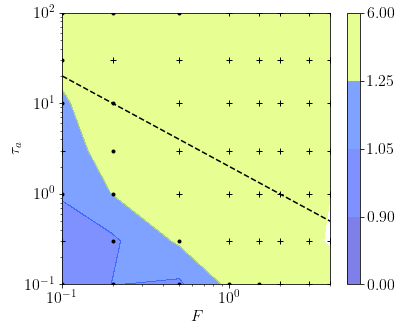

In [126]:
mpl.rcParams.update({'font.size':16, 'text.usetex':True, 'figure.figsize':(6,5)})

cmap = mpl.colors.ListedColormap(['b', 'g', 'y', 'r','m'])

# Xi,Yi=np.meshgrid(np.geomspace(0.01,5,40),np.logspace(-2,3,40))
Xi,Yi=np.meshgrid(np.unique(Fs),np.unique(Tas))
# Xi,Yi=np.meshgrid(np.unique(conf),np.unique(betas))
Xp,Yp=np.meshgrid(np.logspace(-1,1,100), np.logspace(-1,2,100))
triang=tri.Triangulation(Fs,Tas)
# triang=tri.Triangulation(conf,betas)
interpZ=tri.LinearTriInterpolator(triang,np.array(Prob_center)/p1_eq)
Zi=interpZ(Xi,Yi)
# plt.contourf(Xi, Yi, Zi, levels=np.arange(0.0,1.5,0.001),cmap='jet',)
plt.contourf(Xi, Yi, Zi, levels=[0.0, 0.9,1.05,1.25,6],cmap='jet',alpha=0.5)
plt.colorbar()
plt.contour(Xp,Yp,Xp*Yp/(0.1*20), levels=[1],colors='k',linestyles='dashed')

for ix in range(len(Fs)):
    if Peak[ix]=='eq-like':
        plt.plot(Fs[ix],Tas[ix],'k+',)
    elif Peak[ix]=='boundary-peak':
        plt.plot(Fs[ix],Tas[ix],'k.',)
    elif Peak[ix]=='coex':
        plt.plot(Fs[ix],Tas[ix],'k.',)
    else: print(Fs[ix],Tas[ix])
    
plt.xlabel('$F$')
plt.ylabel('$\\tau_a$')
# plt.xlim(1,1e3)

plt.loglog()
# plt.title('Average radial position $\\langle R\\rangle/R_{eq}$')
plt.xlim(0.1,max(Fs))
plt.ylim(min(Tas),max(Tas))
# plt.axhline(10,c='k')
plt.savefig(fpath+'plots/comRDP_regime_diag.png', dpi=300, bbox_inches='tight')


2
56


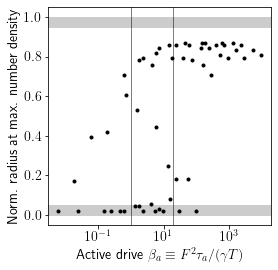

In [133]:
mpl.rcParams.update({'font.size':14, 'text.usetex':True, 'figure.figsize':(4,4)})
#fig,[ax1,ax2,ax]=plt.subplots(1,3,figsize=(15,4),gridspec_kw={'wspace':0.4, 'hspace':0.4})
print(len(R_pmax_b))
colors = pl.cm.gist_rainbow(np.linspace(0,1,len(R_pmax_b[0])))

Yy=[y/20 for x,y in sorted(zip(Fs,R_pmax_b[0]))]
Xx =[y for x,y in sorted(zip(Fs,R_pmax_b[1]))]
print(len(Yy))
plt.semilogx(Xx,Yy,'k.',)
plt.ylim(-0.05,1.05)
# plt.axvspan(1,20,color='0.8',)
plt.axvline(1,c='k',lw=0.5)
plt.axvline(20,c='k',lw=0.5)
plt.axhspan(0,1/20,color='0.8')
plt.axhspan(19/20,1,color='0.8')
plt.xlabel('Active drive $\\beta_a\\equiv F^2\\tau_a/(\\gamma T)$')
plt.ylabel('Norm. radius at max. number density')
plt.savefig(fpath+'plots/R_maxPcom_beta.png', dpi=300, bbox_inches='tight')


0 0 0


ValueError: z array must have same length as triangulation x and y arrays

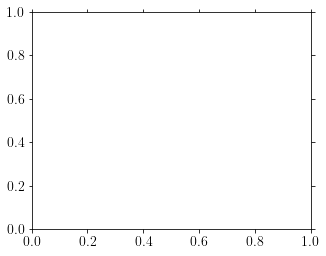

In [154]:
fig,ax=plt.subplots(1,1,figsize=(5,4),gridspec_kw={'wspace':0.4, 'hspace':0.4})
ax.clear()
print(len(conf), len(betas), len(Rpp))
# Xi,Yi=np.meshgrid(np.geomspace(0.01,5,40),np.logspace(-2,3,40))
Xi,Yi=np.meshgrid(np.unique(Fs),np.unique(Tas))
# Xi,Yi=np.meshgrid(np.unique(conf),np.unique(betas))
Xp,Yp=np.meshgrid(np.logspace(-4,1,100), np.logspace(-4,4,100))
triang=tri.Triangulation(Fs,Tas)
# triang=tri.Triangulation(conf,betas)
interpZ=tri.LinearTriInterpolator(triang,np.array(Rpp))
Zi=interpZ(Xi,Yi)
plt.contourf(Xi, Yi, Zi, levels=np.arange(0.01,0.16,0.002),cmap='gist_rainbow',)
plt.colorbar()
plt.contour(Xp,Yp,Xp**2*Yp/(0.1*0.0083*200), levels=[1],colors='k',)
plt.contour(Xp,Yp,Xp*Yp/(0.1*20), levels=[1],colors='k',)
# plt.contour(Xi,Yi,Xi*Yi/(0.1*40), levels=[1],colors='k',alpha=0.3)

for ix in range(len(Fs)):
    if Rp[ix]=='eq-like':
        plt.plot(Fs[ix],Tas[ix],'w+',)
    elif Rp[ix]=='boundary-peak':
        plt.plot(Fs[ix],Tas[ix],'k.',)
    elif Rp[ix]=='coex':
        plt.plot(Fs[ix],Tas[ix],'x',c='0.5')
    # elif Rp[ix]==3:
    #     plt.plot(Fs[ix],Tas[ix],'k.',)

# interpZp=tri.LinearTriInterpolator(triang,np.around(np.array(Rpp), 3))
# Zp=interpZp(Xi,Yi)
# plt.contourf(Xi, Yi, Zp, levels=[0,1,2], hatches=['/','.','////'], colors='None')
# plt.colorbar()
# plt.contour(Xi, Yi, Zi, levels=[1,], colors='k')
# plt.contour(Xi, Yi, Zp, levels=[1.], colors='k')
# cs= plt.contour(Xi,Yi,Xi**2*Yi/(0.1*0.0083*T0), colors='k', levels=[1, 10,1e2,1e3],)

# plt.clabel(cs, cs.levels, inline=True,fmt=fmt, fontsize=16)
# plt.plot(Fs,Tas,'k+',)
# for fval,taval,lc in [(0.0,1.0,'r'),(0.3,1,'c'),(2,1,'m'),(2,100,'b'),(0.3,100,'g')]:
    # plt.plot(fval,taval,'o',markersize=10,color=lc)

plt.xlabel('$F$')
plt.ylabel('$\\tau_a$')
# plt.xlim(1,1e3)

plt.loglog()
# plt.title('Average radial position $\\langle R\\rangle/R_{eq}$')
plt.xlim(0.01,5)
plt.ylim(0.01,1e3)
# plt.axhline(10,c='k')
plt.savefig(fpath+'plots/RDP_regime_diag.png', dpi=300, bbox_inches='tight')


(2000, 1200, 3)
(2000,)


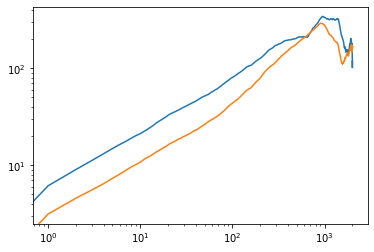

In [15]:
ind=4

fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()

norm = mpl.colors.Normalize(vmin=0, vmax=0.6)
cmap = cm.gist_rainbow
m = cm.ScalarMappable(norm=norm, cmap=cmap)
# print(m.to_rgba(x))
Ts,Fs,Tas=[],[],[]
Rmax=[]
betas=[]
T0=200
fpath='../../data/SAC_AB/RDP/'

for fname in os.listdir(fpath):
    if '.npz' in fname and 'RadNumDens_A' in fname and 'rep1' in fname:
        # print(fname)#.split('_'))
        T= float(fname.split('_')[ind].replace('T',''))
        F=float(fname.split('_')[ind+1].replace('F',''))
        Ta=float(fname.split('_')[ind+2].replace('Ta',''))
        kb=float(fname.split('_')[ind+7].replace('kb',''))
        Esoft=float(fname.split('_')[ind+3].replace('Esoft',''))
        R0=float(fname.split('_')[ind+4].replace('R0',''))
        dt=float(fname.split('_')[ind+8].replace('dt',''))
        # print(T,F,Ta,Esoft,R0)
        if kb==5: continue
        if T==T0:
            npzfile=np.load(fpath+fname)
       
            b_act=F**2*Ta/(0.1*0.0083*T)

            betas.append(b_act)
            Ts.append(T)
            Tas.append(Ta)
            Fs.append(F)

            Rm=npzfile['bins'][np.where(npzfile['hist']==npzfile['hist'].max())][0]
            Rav=simps(npzfile['bins']**3*4*np.pi*npzfile['hist']/1200,npzfile['bins'])
            Rsd=np.sqrt(simps((npzfile['bins']-Rav)**2*4*np.pi*npzfile['bins']*npzfile['hist']/1200,npzfile['bins']))
            # print(Rav)

            Rav=np.mean(npzfile['hist'][1:5])
            Rmax.append((F,Ta,b_act,Rav, Rsd**2/Rav))
        
print(len(Rmax))
Xi,Yi=np.meshgrid(np.logspace(-1,1,10),np.logspace(0,3,10))
triang=tri.Triangulation(Fs,Tas)
interpZ=tri.LinearTriInterpolator(triang,[xx[3] for xx in Rmax])#, kind='geom')
Zi=interpZ(Xi,Yi)
# plt.contourf(Xi, Yi, Zi, levels=np.arange(0.,0.2,0.01),cmap='RdBu')
# plt.colorbar()
plt.plot([xx[2] for xx in Rmax],[xx[3] for xx in Rmax],'o')
# cs= plt.contour(Xi,Yi,Xi**2*Yi/(0.1*0.0083*T0), colors='k', levels=[10],)

# plt.clabel(cs, cs.levels, inline=True,fmt=fmt, fontsize=16)

# plt.plot(Fs,Tas,'.',c='b',markersize=5)
plt.xlabel('$F$')
plt.ylabel('$\\tau_a$')
plt.title('Average radial position ($T={:.0f}$)'.format(T0))

plt.loglog()
# plt.savefig('../../plots/Rouse/avg_radial_pos_Ft_T200.png', dpi=300,bbox_inches='tight')

NameError: name 'cm' is not defined

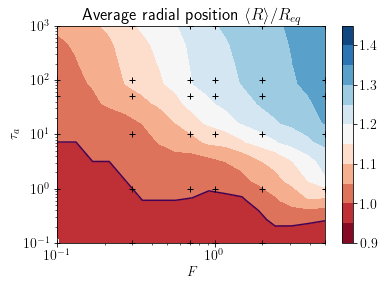

In [41]:
ind=4
# norm = mpl.colors.Normalize(vmin=0, vmax=0.6)
# cmap = mpl.colors.gist_rainbow
# m = cm.ScalarMappable(norm=norm, cmap=cmap)
# print(m.to_rgba(x))
Ts,Fs,Tas=[],[],[]
Rmax=[]
betas=[]
T0=100
Rav_eq=0
fpath='../../data/SAC_exp/RDP/'

for fname in os.listdir(fpath):
    if '.npz' in fname and 'RadNumDens' in fname:
        # print(fname)#.split('_'))
        T= float(fname.split('_')[ind].replace('T',''))
        F=float(fname.split('_')[ind+1].replace('F',''))
        Ta=float(fname.split('_')[ind+2].replace('Ta',''))
        kb=float(fname.split('_')[ind+7].replace('kb',''))
        Esoft=float(fname.split('_')[ind+3].replace('Esoft',''))
        R0=float(fname.split('_')[ind+4].replace('R0',''))
        dt=float(fname.split('_')[ind+8].replace('dt',''))
        # print(T,F,Ta,Esoft,R0)
        
        npzfile=np.load(fpath+fname)
    
        b_act=F**2*Ta/(0.1*0.0083*T)

        betas.append(b_act)
        Ts.append(T)
        Tas.append(Ta)
        Fs.append(F)
        Rav=simps(npzfile['bins']**3*4*np.pi*npzfile['hist']/1200,npzfile['bins'])
        Rm=npzfile['bins'][np.where(npzfile['hist']==npzfile['hist'].max())][0]
        Rmax.append(Rav)

        if F==0: Rav_eq=Rav

Xi,Yi=np.meshgrid(np.geomspace(0.05,5,20),np.logspace(-2,3,15))
triang=tri.Triangulation(Fs,Tas)
interpZ=tri.LinearTriInterpolator(triang,np.around(np.array(Rmax)/Rav_eq, 2))
Zi=interpZ(Xi,Yi)
plt.contourf(Xi, Yi, Zi, levels=np.arange(0.9,1.5,0.05),cmap='RdBu')
plt.colorbar()
plt.contour(Xi, Yi, Zi, levels=[1])
# cs= plt.contour(Xi,Yi,Xi**2*Yi/(0.1*0.0083*T0), colors='k', levels=[1, 10,1e2,1e3],)

# plt.clabel(cs, cs.levels, inline=True,fmt=fmt, fontsize=16)

plt.plot(Fs,Tas,'k+',)
plt.xlabel('$F$')
plt.ylabel('$\\tau_a$')
# plt.xlim(1,1e3)

plt.loglog()
plt.title('Average radial position $\\langle R\\rangle/R_{eq}$')
plt.xlim(0.1,5)
plt.ylim(0.1,1e3)
plt.savefig('../../data/SAC_exp/plots/normAvgR_contour.png', dpi=300, bbox_inches='tight')

In [34]:
ind=4

fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()

norm = mpl.colors.Normalize(vmin=0, vmax=0.6)
cmap = cm.gist_rainbow
m = cm.ScalarMappable(norm=norm, cmap=cmap)
# print(m.to_rgba(x))
Ts,Fs,Tas=[],[],[]
Rmax=[]
betas=[]
T0=100
for fpath in ['../../data/ROUSE_chain_confined_Ns/']:#,'../../data/ROUSE_chain_confined_Ns/N300/']:

    for fname in os.listdir(fpath):
        if '.npz' in fname and 'RDP' in fname:
            # print(fname)#.split('_'))
            T= float(fname.split('_')[ind].replace('T',''))
            F=float(fname.split('_')[ind+1].replace('F',''))
            Ta=float(fname.split('_')[ind+2].replace('Ta',''))
            kb=float(fname.split('_')[ind+7].replace('kb',''))
            Esoft=float(fname.split('_')[ind+3].replace('Esoft',''))
            R0=float(fname.split('_')[ind+4].replace('R0',''))
            dt=float(fname.split('_')[ind+8].replace('dt',''))
            # print(T,F,Ta,Esoft,R0)
            if R0!=10: continue
            npzfile=np.load(fpath+fname)
            # print(npzfile['bins'].shape)
        
            b_act=F**2*Ta/(0.1*T)

            betas.append(b_act)
            Ts.append(T)
            Tas.append(Ta)
            Fs.append(F)

            Rm=npzfile['bins'][np.where(npzfile['hist'][0]==npzfile['hist'][0].max())][0]
            Rmax.append(Rm/R0)

Xi,Yi=np.meshgrid(np.logspace(0,3,10),np.logspace(-3,3,20))
triang=tri.Triangulation(Tas, betas)
interpZ=tri.LinearTriInterpolator(triang,Rmax)
Zi=interpZ(Xi,Yi)
plt.contourf(Xi, Yi, Zi, levels=np.arange(0.,1.2,0.1),cmap='RdBu')
plt.colorbar()

# cs= plt.contour(Xi,Yi,Xi**2*Yi/(0.1*0.0083*T0), colors='k', levels=[1, 10,1e2,1e3],)

# plt.clabel(cs, cs.levels, inline=True,fmt=fmt, fontsize=16)

plt.plot(Tas,betas,'.',c='b',markersize=5)

plt.loglog()


KeyboardInterrupt: 

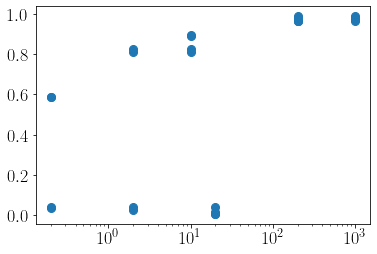

In [123]:
plt.semilogx(betas,Rmax,'o')

Text(0, 0.5, '$F^2\\tau_a/(\\gamma T)$')

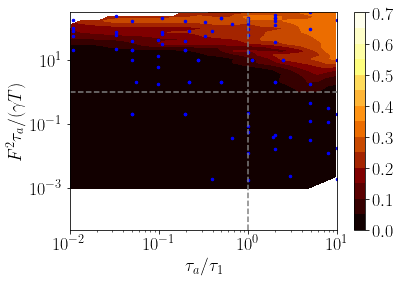

In [598]:
Xi,Yi=np.meshgrid(np.logspace(-3,2,50),np.logspace(-3,4,60))
triang=tri.Triangulation(X,Y)
interpZ=tri.LinearTriInterpolator(triang,Z)
Zi=interpZ(Xi,Yi)
plt.contourf(Xi, Yi, Zi, levels=np.linspace(0,0.7,15),cmap='afmhot')#,alpha=0.6)
        #ax.contour(Xi, Yi, Zi,colors='k',levels=levels,linewidths=0.3)


plt.plot(X,Y,'.',c='b',markersize=5)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-2,10)
plt.ylim(5e-5,3e2)
plt.axhline(1,c='0.5',ls='--',)
plt.axvline(1,c='0.5',ls='--',)

# plt.grid(True,alpha=0.5,which='both')

plt.colorbar()
plt.xlabel('$\\tau_a/\\tau_1$')
plt.ylabel('$F^2\\tau_a/(\gamma T)$')
# plt.savefig('../plots/Rouse/RC_RDP_phase_diag.png',dpi=300, bbox_inches='tight')

#confined_N300 and _N100_new

In [545]:
f=0.003
T=0.8
Ta=350
t1=tau_p(1,5,300)
print('{:.1f} {:.3f} {:.3f}'.format(t1, Ta/t1,f**2*Ta/(0.02*T)))


182.4 1.919 0.197


In [13]:
a=np.array([1,32,4])
b=np.array([4,3,8])

np.pad(a,(0,2))

array([ 1, 32,  4,  0,  0])